### Context

To minimize loss from the bank’s perspective, the bank needs a decision rule regarding whom to approve the loan and whom not to. An applicant’s demographic and socio-economic profiles are considered by loan managers before a decision is taken regarding his/her loan application.
In this dataset, each entry represents a person who takes credit from a bank. Each person is classified as a good or bad credit risk according to the set of attributes. 
 

### Objective:
The objective is to build a predictive model on this data to help the bank decide on whether to approve a loan to a prospective applicant.

 
### Dataset:
- Age (Numeric: Age in years)
- Sex (Categories: male, female)
- Job (Categories: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (Categories: own, rent, or free)
- Saving accounts (Categories: little, moderate, quite rich, rich)
- Checking account (Categories: little, moderate, rich)
- Credit amount (Numeric: Amount of credit in DM - Deutsche Mark)
- Duration (Numeric: Duration for which the credit is given in months)
- Purpose (Categories: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (0 - Person is not at risk, 1 - Person is at risk(defaulter))

## Let's start by importing necessary libraries

In [53]:
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit from the number of displayed columns and rows.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# To build sklearn model
from sklearn.linear_model import LogisticRegression

# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

## Load and overview the dataset

In [54]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
data = pd.read_csv("German_Credit.csv")

In [55]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


### Understand the shape of the dataset.

In [56]:
data.shape

(1000, 10)

### Check the data types of the columns in the dataset.

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


- There are total 10 columns and 1,000 observations in the dataset

- We can see that 2 columns have less than 1,000 non-null values i.e. columns have missing values.

### Check and treat missing values

In [6]:
pd.DataFrame(
    data={
        "% of Missing Values": round(data.isna().sum() / data.isna().count() * 100, 2)
    }
)

,% of Missing Values
Age,0.0
Sex,0.0
Job,0.0
Housing,0.0
Saving accounts,18.3
Checking account,39.4
Credit amount,0.0
Duration,0.0
Purpose,0.0
Risk,0.0


* We can see that two columns - 'Saving accounts' and 'Checking account' have 18% and 39% missing values respectively.
* We can either drop these columns or drop rows with missing values but then we would lose data for such a small dataset.
* As both of these columns are categorical, we can impute the missing values with a new category.

In [7]:
data['Saving accounts'].fillna(value='unknown',inplace=True)
data['Checking account'].fillna(value='unknown',inplace=True)
data.isna().sum()/len(data.isna())

Age                 0.0
Sex                 0.0
Job                 0.0
Housing             0.0
Saving accounts     0.0
Checking account    0.0
Credit amount       0.0
Duration            0.0
Purpose             0.0
Risk                0.0
dtype: float64

**Let's check the number of unique values in each column**

In [8]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

- Age has only 53 unique values i.e. most of the customers are of similar age
- We have only three continuous variables - Age, Credit Amount, and Duration.
- All other variables are categorical

**Checking the value count for each category of categorical variables** 

In [9]:
# Making a list of all catrgorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

male      690
female    310
Name: Sex, dtype: int64
----------------------------------------
2    630
1    200
3    148
0     22
Name: Job, dtype: int64
----------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
----------------------------------------
little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
----------------------------------------
unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
----------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64
----------------------------------------
0    700
1    300
Name: Risk, dtype: int64
----------------------------------------


- We have more male customers as compared to female customers
- There are very few observations i.e., only 22 for customers with job category - unskilled and non-resident
- We can see that the distribution of classes in the target variable is imbalanced i.e., only 30% observations with defaulters.

**Summary of the data**

In [10]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,1000,5,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,1000,4,unknown,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,1000.0,NaN,NaN,NaN,0.3,0.458487,0.0,0.0,0.0,1.0,1.0


**Observations**

- Mean value for the age column is approx 35 and the median is 33. This shows that majority of the customers are under 35 years of age.
- Mean amount of credit is approx 3,271 but it has a wide range with values from 250 to 18,424. We will explore this further in univariate analysis.
- Mean duration for which the credit is given is approx 21 months.
- Most of the customers are not at risk

## Univariate analysis

In [11]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, color="orange"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2, color="tab:cyan"
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

### Observation on Age 

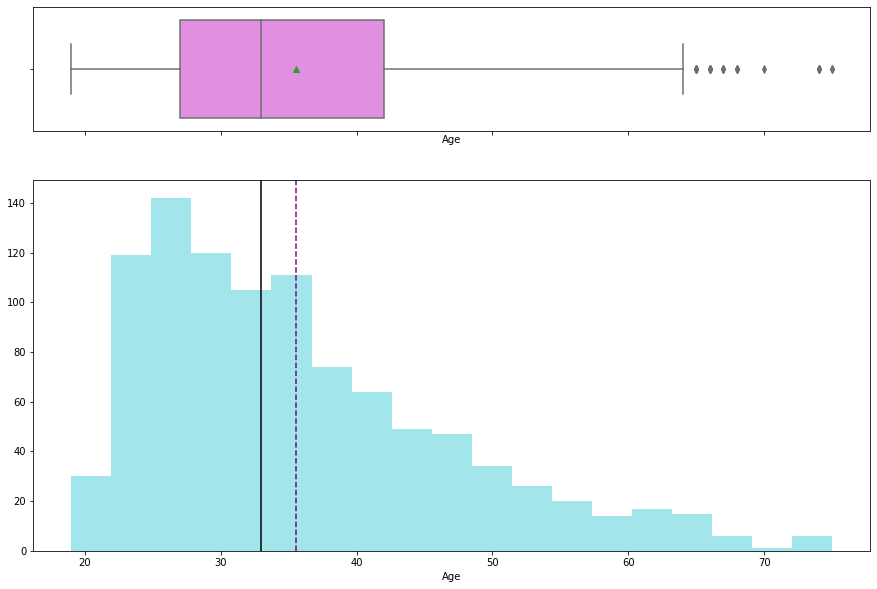

In [12]:
histogram_boxplot(data["Age"])

- The distribution of age is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observation on Credit Amount

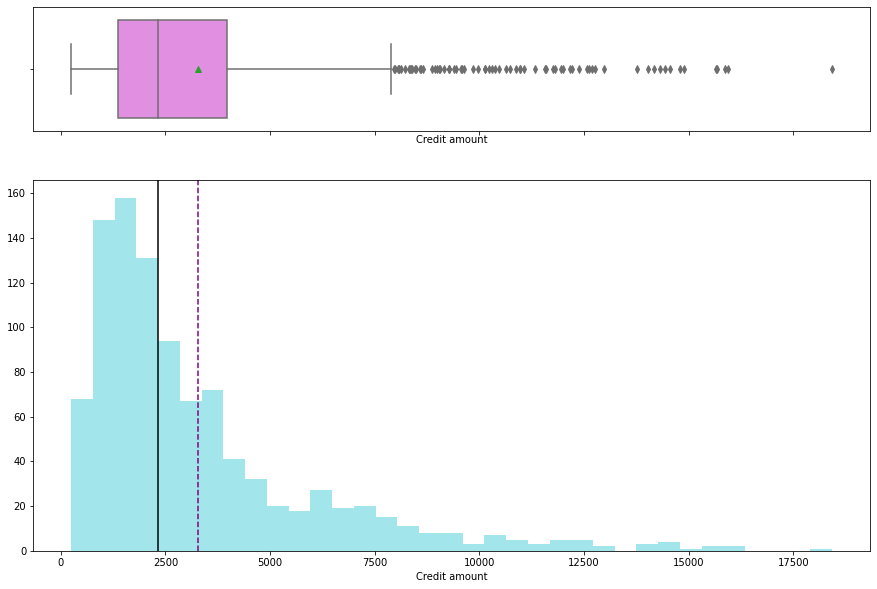

In [13]:
histogram_boxplot(data["Credit amount"])

- The distribution of the credit amount is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observations on Duration

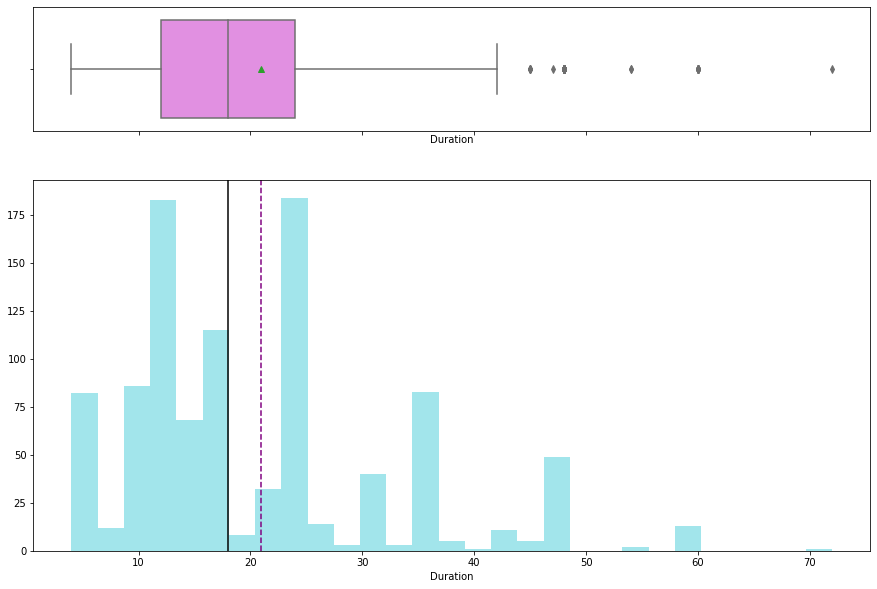

In [14]:
histogram_boxplot(data["Duration"])

- The distribution of the duration for which the credit is given is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

In [15]:
# Function to create barplots that indicate percentage for each category.


def perc_on_bar(plot, feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage
    plt.show()  # show the plot

### Observations on Risk

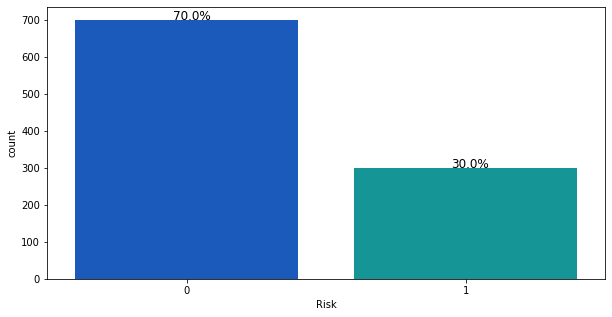

In [16]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Risk"], palette="winter")
perc_on_bar(ax, data["Risk"])

- As mentioned earlier, the class distribution in the target variable is imbalanced.
- We have 70% observations for non-defaulters and 30% observations for defaulters.

### Observations on Sex of Customers

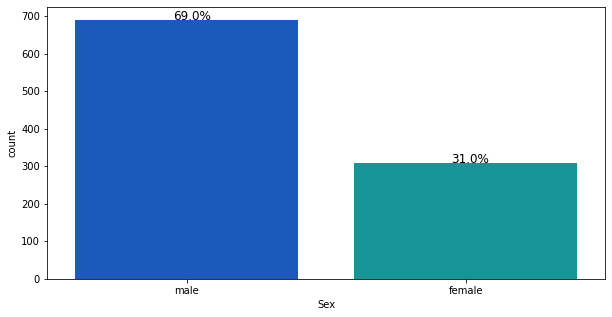

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Sex"], palette="winter")
perc_on_bar(ax, data["Sex"])

- Male customers are taking more credit than female customers
- There are 69% male customers and 31% female customers

### Observations on Housing

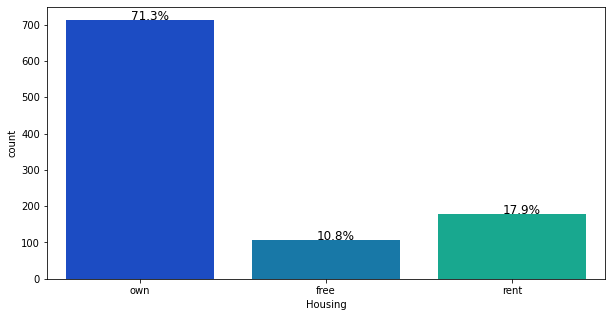

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Housing"], palette="winter")
perc_on_bar(ax, data["Housing"])

- Major of the customers, approx 71%, who take credit have their own house
- Approx 18% customers are living in a rented house
- There are only 11% customers who have free housing. These are the customers who live in a house given by their company or organization

### Observations on Job

* Encoding Job back to the categories:- Job (Categories: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

In [19]:
data['Job'].replace(0,'unskilled_and_non-resident',inplace=True)
data['Job'].replace(1,'unskilled_and_nresident',inplace=True)
data['Job'].replace(2,'skilled',inplace=True)
data['Job'].replace(3,'highly skilled',inplace=True)

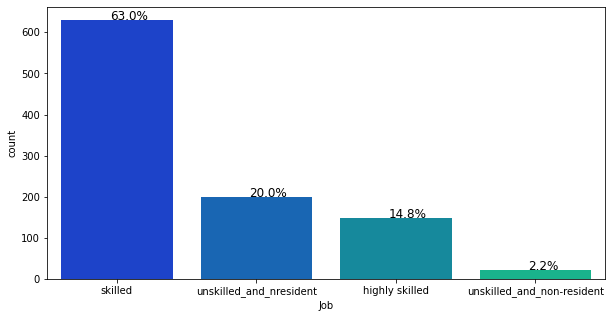

In [20]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Job"], palette="winter")
perc_on_bar(ax, data["Job"])

- Majority of the customers i.e. 63% fall into the skilled category.
- There are only approx 15% customers that lie in highly skilled category which makes sense as these may be the persons with high education or highly experienced.
- There are very few observations, approx 22%, with 0 or 1 job category.

### Observations on Saving accounts

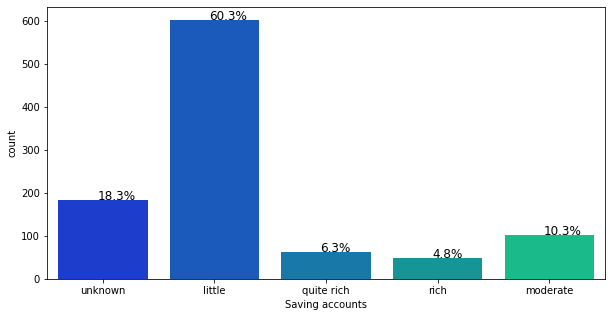

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Saving accounts"], palette="winter")
perc_on_bar(ax, data["Saving accounts"])

- Approx 70% customers who take credit have a little or moderate amount in their savings account. This makes sense as these customers would need credit more than the other categories.
- Approx 11% customers who take credit are in the rich category based on their balance in the savings account.
- Note that the percentages do not add up to 100 as we have missing values in this column.

### Observations on Checking account

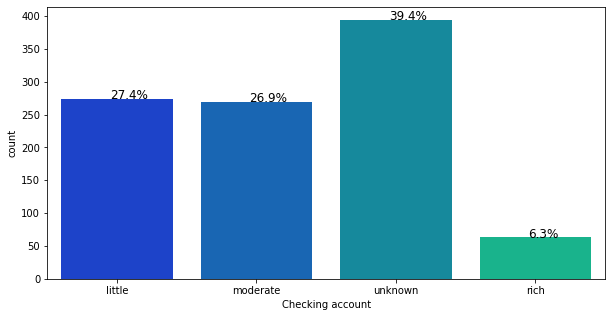

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Checking account"], palette="winter")
perc_on_bar(ax, data["Checking account"])

- Approx 54% customers who take credit have a little or moderate amount in their checking account. This makes sense as these customers would need credit more than the other categories.
- Approx 6% customers who take credit are in the rich category based on their balance in the checking account.
- Note that the percentages do not add up to 100 as we have missing values in this column.

### Observations on Purpose

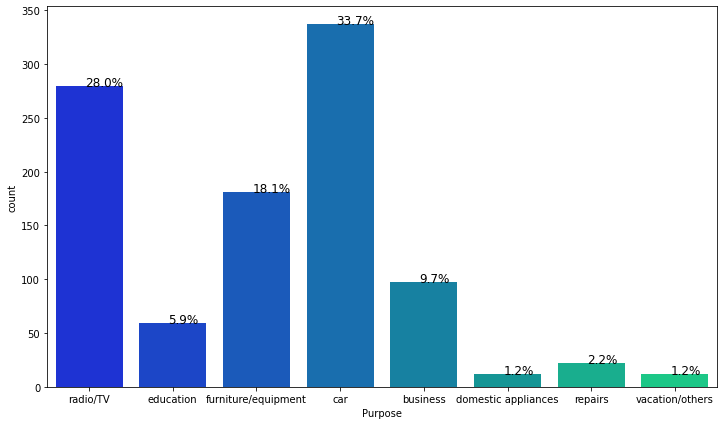

In [23]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(data["Purpose"], palette="winter")
perc_on_bar(ax, data["Purpose"])

- The plot shows that most customers take credit for luxury items like car, radio or furniture/equipment, domestic appliances.
- Approximately just 16% customers take credit for business or education

## Bivariate Analysis

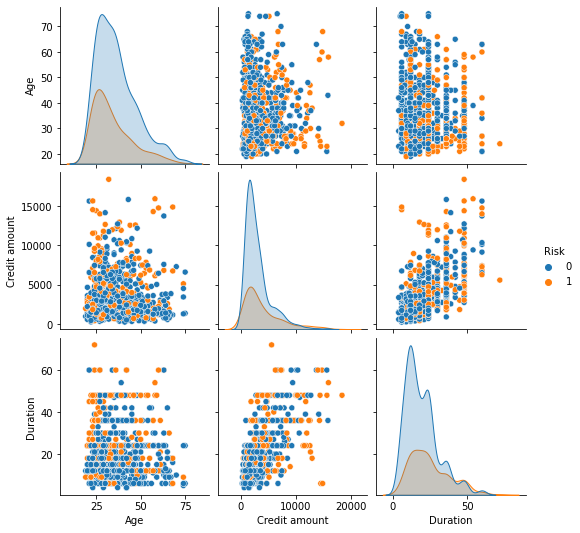

In [24]:
sns.pairplot(data, hue="Risk")
plt.show()

- There are overlaps i.e., no clear distinction in the distribution of variables for people who have defaulted and did not default.
- Let's explore this further with the help of other plots.

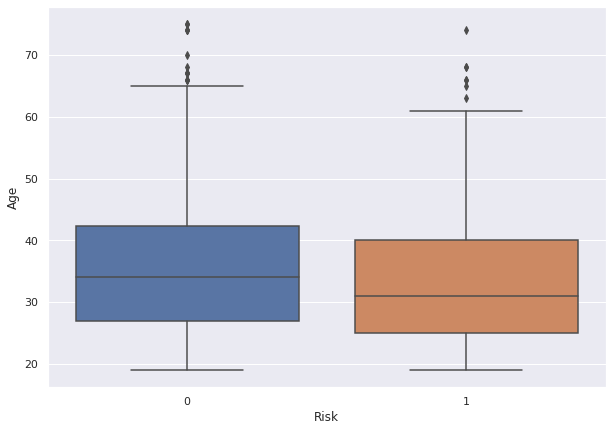

In [25]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Age", data=data, orient="vertical")
plt.show()

- We can see that the median age of defaulters is less than the median age of non-defaulters.
- This shows that younger customers are more likely to default.
- There are outliers in boxplots of both class distributions

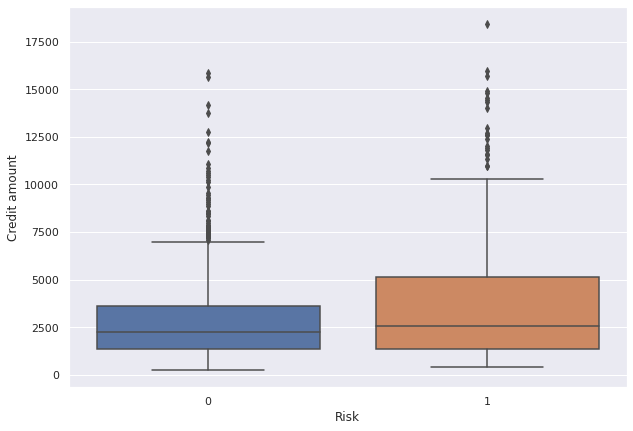

In [26]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Credit amount", data=data, orient="vertical")
plt.show()

- We can see that the third quartile amount of defaulters is much more than the third quartile amount of non-defaulters.
- This shows that customers with high credit amount are more likely to default.
- There are outliers in boxplots of both class distributions

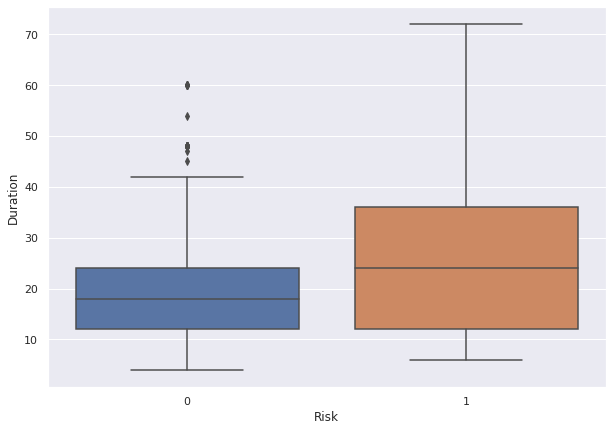

In [27]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Duration", data=data, orient="vertical")
plt.show()

- We can see that the second and third quartiles of duration of defaulters is much more than the second and third quartiles duration of non-defaulters.
- This shows that customers with high duration are more likely to default.

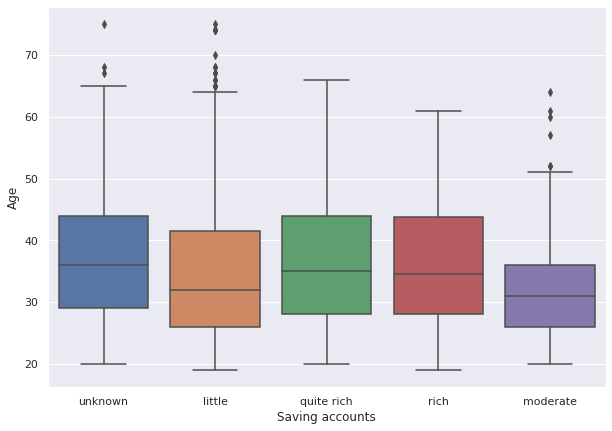

In [28]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Saving accounts", y="Age", data=data)
plt.show()

- The plot shows that customers with higher age are in the rich or quite rich categories.
- Age of the customers in the little and moderate categories is slightly less but there are outliers in both of the distributions.

In [29]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, data["Risk"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, data["Risk"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    # plt.legend(loc='lower left', frameon=False)
    # plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

Risk      0    1   All
Sex                   
female  201  109   310
male    499  191   690
All     700  300  1000
------------------------------------------------------------------------------------------------------------------------


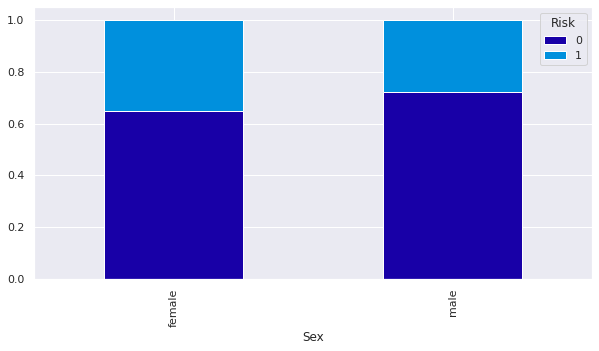

In [30]:
stacked_plot(data["Sex"])

- We saw earlier that the percentage of male customers is more than the female customers. This plot shows that female customers are more likely to default as compared to male customers.

Risk                          0    1   All
Job                                       
highly skilled               97   51   148
skilled                     444  186   630
unskilled_and_non-resident   15    7    22
unskilled_and_nresident     144   56   200
All                         700  300  1000
------------------------------------------------------------------------------------------------------------------------


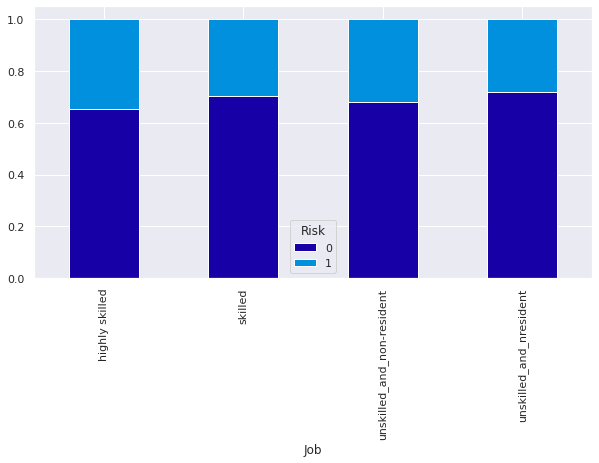

In [31]:
stacked_plot(data["Job"])

- There are no significant difference with respect to the job level
- However, highly skilled or unskilled/non-resident customers are more likely to default as compared to customers in 1 or 2 category 

Risk       0    1   All
Housing                
free      64   44   108
own      527  186   713
rent     109   70   179
All      700  300  1000
------------------------------------------------------------------------------------------------------------------------


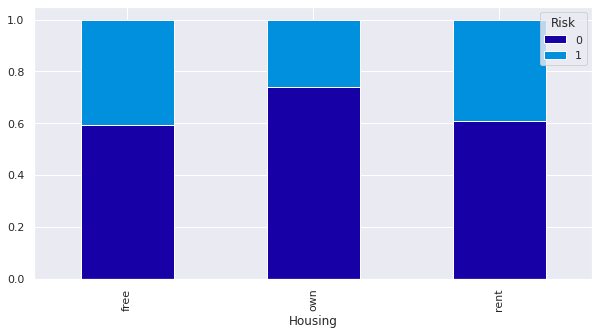

In [32]:
stacked_plot(data['Housing'])

- Customers owning a house are less likely to default
- Customers with free or rented housing are almost at same risk of default

Risk               0    1   All
Saving accounts                
little           386  217   603
moderate          69   34   103
quite rich        52   11    63
rich              42    6    48
unknown          151   32   183
All              700  300  1000
------------------------------------------------------------------------------------------------------------------------


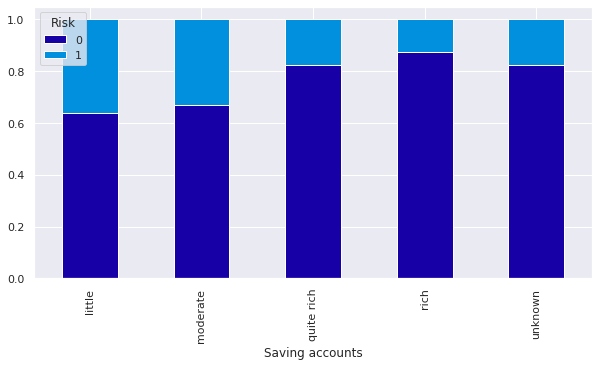

In [33]:
stacked_plot(data["Saving accounts"])

- As we saw earlier, customers with little or moderate amounts in saving accounts takes more credit but at the same time they are most likely to default.
- Rich customers are slightly less likely to default as compared to quite rich customers

Risk                0    1   All
Checking account                
little            139  135   274
moderate          164  105   269
rich               49   14    63
unknown           348   46   394
All               700  300  1000
------------------------------------------------------------------------------------------------------------------------


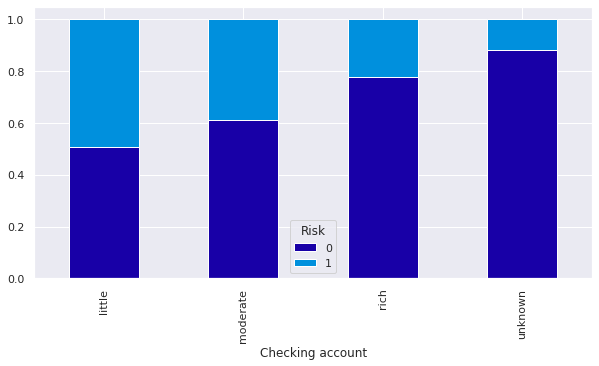

In [34]:
stacked_plot(data['Checking account'])

- The plot further confirms the findings of the previous plot.
- Customers with little amount in checking accounts are most likely to default as compared to customers with moderate amount, which in turn, are more likely as compared to the rich customers.

Risk                   0    1   All
Purpose                            
business              63   34    97
car                  231  106   337
domestic appliances    8    4    12
education             36   23    59
furniture/equipment  123   58   181
radio/TV             218   62   280
repairs               14    8    22
vacation/others        7    5    12
All                  700  300  1000
------------------------------------------------------------------------------------------------------------------------


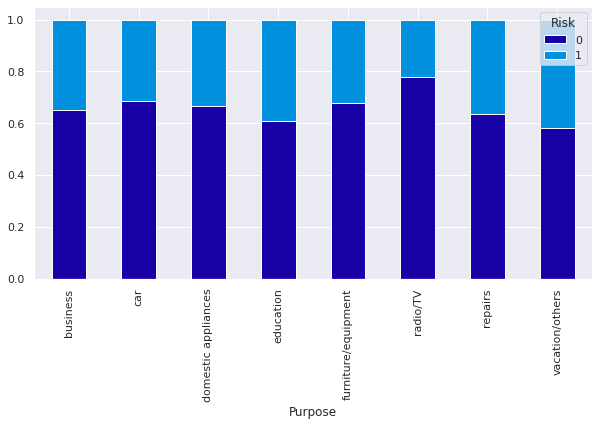

In [35]:
stacked_plot(data["Purpose"])

- Customers who take credit for radio/TV are least likely to default. This might be because their credit amount is small.
- Customers who take credit for education or vacation are most likely to default.
- Other categories have no significant difference between their default and non-default ratio.

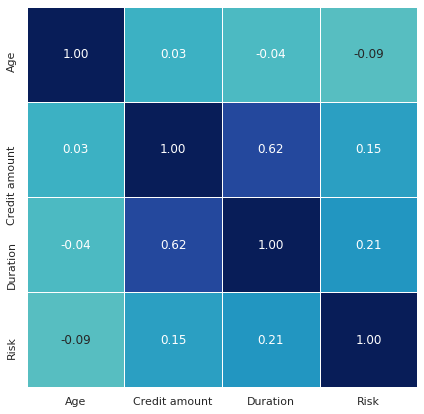

In [36]:
sns.set(rc={"figure.figsize": (7, 7)})
sns.heatmap(
    data.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

- Credit amount and duration have positive correlation which makes sense as customers might take the credit for longer duration if the amount of credit is high.
- Other variables have no significant correlation between them.

### Model evaluation criterion

### Model can make wrong predictions as:

1. Predicting a customer is not going to default but he does - Loss of resources
2. Predicting a customer is going to default but he doesn't - Loss of opportunity


### Which Loss is greater ? 

* Loss of opportunity will be the greater loss.

### How to reduce this loss i.e need to reduce False Negatives ?
* Company would want to reduce false negatives, this can be done by maximizing the Recall. Greater the recall lesser the chances of false negatives.

#### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The get_metrics_score function will be used to check the performance of models.

In [37]:
def get_metrics_score(model,train,test,train_y,test_y,threshold=0.5,flag=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier to predict values of X
    train, test: Independent features
    train_y,test_y: Dependent variable
    threshold: thresold for classifiying the observation as 1
    flag: If the flag is set to True then only the print statements showing different will be displayed. The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = (model.predict_proba(train)[:,1]>threshold)
    pred_test = (model.predict_proba(test)[:,1]>threshold)

    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
   
    if roc == True:
        print("ROC-AUC Score on training set : ",roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score on test set : ",roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [38]:
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_X)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data Preparation

In [39]:
# Converting monthly values to yearly, it will help to have variables with similar scale or small scale.
data['Duration'] = data['Duration'] / 12 

In [40]:
X = data.drop('Risk',axis=1)
Y = data['Risk']

# creating dummy variables
X = pd.get_dummies(X,drop_first=True)

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42)

### Logistic Regression

Accuracy on training set :  0.7557142857142857
Accuracy on test set :  0.7233333333333334
Recall on training set :  0.3923444976076555
Recall on test set :  0.31868131868131866
Precision on training set :  0.6507936507936508
Precision on test set :  0.58
F1 on training set :  0.48955223880597015
F1 on test set :  0.41134751773049644


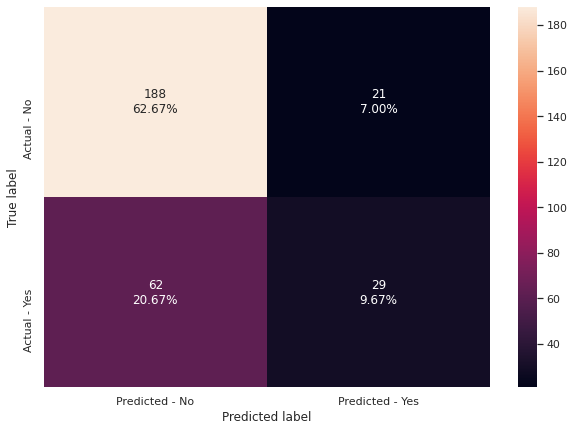

In [41]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is faster for high-dimensional data

model = LogisticRegression(solver='newton-cg',random_state=1)
lg = model.fit(X_train,y_train)

# creating confusion matrix
make_confusion_matrix(lg,X_test,y_test)

# checking model performance
scores_LR = get_metrics_score(lg,X_train,X_test,y_train,y_test,flag=True)

#### ROC-AUC

* ROC-AUC on training set

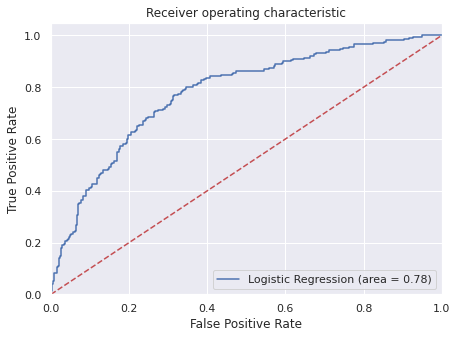

In [42]:
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:,1])
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

* ROC-AUC on test set

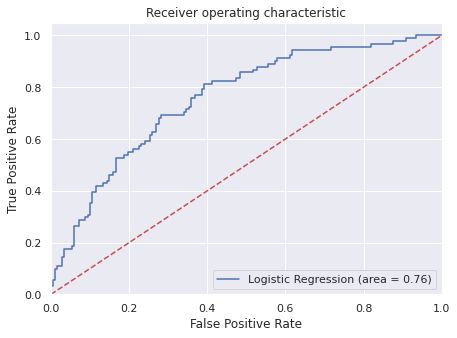

In [43]:
logit_roc_auc_test = roc_auc_score(y_test, lg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

* Logistic Regression model is giving a good performance on training and test set but the recall is low.

### Finding the coefficients

In [44]:
log_odds = lg.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=['coef']).T

,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Job_unskilled_and_nresident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknown,Checking account_moderate,Checking account_rich,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
coef,-0.031002,0.000035,0.340126,-0.363452,0.01249,-0.124461,-0.034558,-0.649545,-0.310639,-0.127675,-0.536223,-0.810392,-0.527091,-0.334296,-0.770037,-1.543534,-0.01525,0.113782,0.373888,-0.464182,-0.560671,-0.031588,-0.052318


### Coefficient interpretations

* Coefficients of Duration, Credit amount and some categorical levels of Purpose and Job are positive, an increase in these will lead to an increase in chances of a customer being a defaulter. 
* Coefficients of Age, Sex_male, Housing, Saving_accounts, and some categorical levels of Purpose and Job is negative, an increase in these will lead to a decrease in chances of a customer being a defaulter.

###  Converting coefficients to odds

* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

**Odds from coefficients**

In [45]:
odds = np.exp(lg.coef_[0]) # converting coefficients to odds
pd.set_option('display.max_columns',None)  # removing limit from number of columns to display
pd.DataFrame(odds, X_train.columns, columns=['odds']).T # adding the odds to a dataframe

,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Job_unskilled_and_nresident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknown,Checking account_moderate,Checking account_rich,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
odds,0.969473,1.000035,1.405125,0.695272,1.012568,0.882973,0.966033,0.522283,0.732979,0.880139,0.584953,0.444684,0.59032,0.715842,0.462996,0.213625,0.984866,1.120507,1.453374,0.628649,0.570826,0.968906,0.949027


**Percentage change in odds**

In [46]:
perc_change_odds = (np.exp(lg.coef_[0])-1)*100 # finding the percentage change
pd.set_option('display.max_columns',None) # removing limit from number of columns to display
pd.DataFrame(perc_change_odds, X_train.columns, columns=['change_odds%']).T # adding the change_odds% to a dataframe

,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Job_unskilled_and_nresident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknown,Checking account_moderate,Checking account_rich,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
change_odds%,-3.052674,0.003494,40.512525,-30.47281,1.256793,-11.702726,-3.396725,-47.771666,-26.702126,-11.986057,-41.50467,-55.531609,-40.968013,-28.415788,-53.700407,-78.637509,-1.513413,12.050747,45.33743,-37.135086,-42.917411,-3.109436,-5.097284


### Coefficient interpretations

* `Age`: Holding all other features constant a unit change in Age will decrease the odds of a customer being a defaulter by 0.96 times or a 3.05% decrease in the odds.
* `Credit amount`: Holding all other features constant a unit change in Credit amount will increase the odds of a customer being a defaulter by 1.00 times or a 0.003% increase in the odds.
* `Duration`: Holding all other features constant a unit change in Duration will increase the odds of a customer being a defaulter by 1.40 times or a 40.51% increase in the odds.
* `Sex`: The odds of a male customer being a defaulter 0.69 times less than a female customer or 30.47% fewer odds than female.
* `Housing`: The odds of a customer who has own house being a defaulter is 0.52 times less than the customer who lives in a house provided by his organization (Housing - free) or 47.77% fewer odds of being a defaulter. Similarly, The odds of a customer who lives in a rented place being a defaulter is 0.73 times less than the customer who lives in a house provided by his organization (Housing - free) or 26.7% fewer odds of being a defaulter. [Keeping housing_free as reference]

`Interpretation for other attributes can be made similarly.`

### Finding optimal threshold

In [47]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = metrics.roc_curve(y_test, lg.predict_proba(X_test)[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.23807936472411975


In [48]:
scores_LR = get_metrics_score(lg,X_train,X_test,y_train,y_test,threshold=optimal_threshold_auc_roc,roc=True)

Accuracy on training set :  0.6671428571428571
Accuracy on test set :  0.6666666666666666
Recall on training set :  0.8373205741626795
Recall on test set :  0.8021978021978022
Precision on training set :  0.4679144385026738
Precision on test set :  0.47096774193548385
F1 on training set :  0.6003430531732418
F1 on test set :  0.5934959349593496
ROC-AUC Score on training set :  0.7160126292401993
ROC-AUC Score on test set :  0.7049266522950733


* Model performance has improved significantly on training and test set.
* Model is giving a generalized performance.
* Area under the curve has decreased as compared to the initial model but the performance is generalized on training and test set. 

#### Now Let's use Precision-Recall curve and see if we can find a better threshold

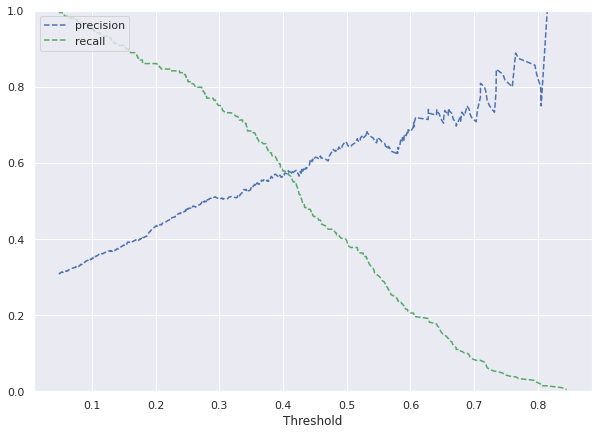

In [49]:
y_scores=lg.predict_proba(X_train)[:,1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* At threshold around 0.41 we will get equal precision and recall but taking a step back and selecting value around 0.37 will provide a higher recall and a good precision.

In [50]:
optimal_threshold_curve = 0.37
# checking model performance
scores_LR = get_metrics_score(lg,X_train,X_test,y_train,y_test,threshold=optimal_threshold_curve,roc=True)

Accuracy on training set :  0.7414285714285714
Accuracy on test set :  0.73
Recall on training set :  0.6507177033492823
Recall on test set :  0.5384615384615384
Precision on training set :  0.5573770491803278
Precision on test set :  0.5568181818181818
F1 on training set :  0.6004415011037527
F1 on test set :  0.547486033519553
ROC-AUC Score on training set :  0.7153792182734191
ROC-AUC Score on test set :  0.6759293338240706


* Recall has improved as compared to the initial model.
* Model is giving a better performance with 0.23 threshold.

In [51]:
# defining list of model
models = [lg]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model,X_train,X_test,y_train,y_test,flag=False)
    k = get_metrics_score(model,X_train,X_test,y_train,y_test,threshold=optimal_threshold_auc_roc,flag=False)
    l = get_metrics_score(model,X_train,X_test,y_train,y_test,threshold=optimal_threshold_curve,flag=False)
    #intial model
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])
    
    #optimal threshold = 0.23  
    acc_train.append(k[0])
    acc_test.append(k[1])
    recall_train.append(k[2])
    recall_test.append(k[3])
    precision_train.append(k[4])
    precision_test.append(k[5])
    f1_train.append(k[6])
    f1_test.append(k[7])
    
    #optimal threshold = 0.37
    acc_train.append(l[0])
    acc_test.append(l[1])
    recall_train.append(l[2])
    recall_test.append(l[3])
    precision_train.append(l[4])
    precision_test.append(l[5])
    f1_train.append(l[6])
    f1_test.append(l[7])

In [52]:
comparison_frame = pd.DataFrame({'Model':['Logistic Regression','Logistic Regression-0.23 Threshold',
                                          'Logistic Regression-0.37 Threshold)'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'Train_F1_Score':f1_train,'Test_F1_Score':f1_test}) 



comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1_Score,Test_F1_Score
0,Logistic Regression,0.755714,0.723333,0.392344,0.318681,0.650794,0.580000,0.489552,0.411348
1,Logistic Regression-0.23 Threshold,0.667143,0.666667,0.837321,0.802198,0.467914,0.470968,0.600343,0.593496
2,Logistic Regression-0.37 Threshold),0.741429,0.730000,0.650718,0.538462,0.557377,0.556818,0.600442,0.547486


- The best test recall is 80% and the test precision is 47%.

## Recommendations

- From our logistic regression model we identified that Duration is a significant predictor of a customer being a defaulter. 
- Bank should target more male customers as they have lesser odds of defaulting.
- We saw in our analysis that customers with a little or moderate amount in saving or checking accounts are more likely to default.  The bank can be more strict with its rules or interest rates to compensate for the risk.
- We saw that customers who have rented or free housing are more likely to default. The bank should keep more details about such customers like hometown addresses, etc. to be able to track them.
- Our analysis showed that younger customers are slightly more likely to default. The bank can alter its policies to deal with this.